# LSTM을 이용한 주가 예측

In [1]:
#!pip install yfinance

In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pylab import rcParams
from sklearn.preprocessing import StandardScaler

import yfinance as yf

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM,Dropout,Dense

- Apple 주식 가격 예측

In [3]:
aapl = yf.download('AAPL', start='2015-01-01', end='2019-12-31', progress=False)
aapl.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2014-12-31,28.205000,28.282499,27.552500,27.594999,24.951860,165613600
2015-01-02,27.847500,27.860001,26.837500,27.332500,24.714506,212818400
2015-01-05,27.072500,27.162500,26.352501,26.562500,24.018259,257142000
2015-01-06,26.635000,26.857500,26.157499,26.565001,24.020521,263188400
2015-01-07,26.799999,27.049999,26.674999,26.937500,24.357340,160423600


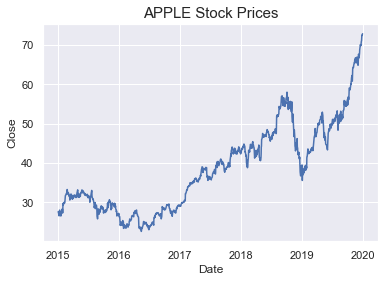

In [4]:
import seaborn as sns
sns.set(style='darkgrid')

#Plot "Close"
plt.title("APPLE Stock Prices", fontsize=15)
sns.lineplot(x=aapl.index, y='Close', data=aapl);

LSTM layer로 하려고 하는 것은 지난 window-size 일(즉, t-window에서 t-1까지)의 역사적 가격을 사용하여 시간 t의 가격을 예측하는 것입니다. 정확한 가격이 아닌 추세를 파악하기 위해 노력할 것임을 명심하십시오.

- training dataset 생성

In [5]:
aapl.shape

(1258, 6)

In [6]:
def series_to_supervised(series, window_size):
    X, y = [], []
    for i in range(len(series)-window_size):
        seq_x = series[i:i+window_size]
        seq_y = series[i+window_size]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)

In [7]:
window = 30
close = aapl['Close']

hist, target = series_to_supervised(close, window)
target = target.reshape(-1, 1)

print(hist.shape)
print(target.shape)

(1228, 30)
(1228, 1)


### 지도학습 데이터 확인 방법 

- "hist"의 각 요소는 window개 timestep의 list입니다. 1씩 증가하기 때문에 "hist"의 두 번째 요소의 마지막 항목은 "target"의 첫 번째 요소와 같아야 합니다. 또한 마지막 숫자가 같아야 합니다.

In [8]:
hist[0]

array([27.59499931, 27.33250046, 26.5625    , 26.56500053, 26.9375    ,
       27.97249985, 28.00250053, 27.3125    , 27.55500031, 27.45000076,
       26.70499992, 26.49749947, 27.18000031, 27.38750076, 28.10000038,
       28.24500084, 28.27499962, 27.28499985, 28.82749939, 29.72500038,
       29.29000092, 29.65749931, 29.66250038, 29.88999939, 29.98500061,
       29.73250008, 29.93000031, 30.50499916, 31.21999931, 31.61499977])

In [9]:
hist[1]

array([27.33250046, 26.5625    , 26.56500053, 26.9375    , 27.97249985,
       28.00250053, 27.3125    , 27.55500031, 27.45000076, 26.70499992,
       26.49749947, 27.18000031, 27.38750076, 28.10000038, 28.24500084,
       28.27499962, 27.28499985, 28.82749939, 29.72500038, 29.29000092,
       29.65749931, 29.66250038, 29.88999939, 29.98500061, 29.73250008,
       29.93000031, 30.50499916, 31.21999931, 31.61499977, 31.77000046])

In [10]:
target[0]

array([31.77000046])

In [11]:
hist[1][-1] == target[0]

array([ True])

In [12]:
len(hist) - 100

1128

1098일의 데이터로 모델을 학습시키고 다음 100일의 데이터로 테스트하는 방식으로 데이터를 분할합니다.

In [13]:
#train/test split
split = len(hist) - 100
time_train = range(split)
time_test = range(100)

X_train = hist[:split]
X_test = hist[split:]
y_train = target[:split]
y_test = target[split:]

time_train, time_test, X_train.shape, X_test.shape, y_train.shape, y_test.shape

(range(0, 1128), range(0, 100), (1128, 30), (100, 30), (1128, 1), (100, 1))

- Feature scaling

In [16]:
sc1 = StandardScaler()
X_train_scaled = sc1.fit_transform(X_train)
X_test_scaled = sc1.transform(X_test)

sc2 = StandardScaler()
y_train_scaled = sc2.fit_transform(y_train)
y_test_scaled = sc2.transform(y_test)

X_train_scaled.shape, X_test_scaled.shape, y_train_scaled.shape, y_test_scaled.shape

((1128, 30), (100, 30), (1128, 1), (100, 1))

In [17]:
X_train_scaled = X_train_scaled.reshape((len(X_train_scaled), window, 1))
X_test_scaled = X_test_scaled.reshape((len(X_test_scaled), window, 1))

X_train_scaled.shape, X_test_scaled.shape

((1128, 30, 1), (100, 30, 1))

- model 생성 및 fitting

In [18]:
model = tf.keras.Sequential()
model.add(LSTM(64, input_shape=(window, 1), return_sequences=True, dropout=0.2))
model.add(LSTM(32, dropout=0.2))
model.add(Dense(10))
model.add(Dense(1))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 30, 64)            16896     
                                                                 
 lstm_1 (LSTM)               (None, 32)                12416     
                                                                 
 dense (Dense)               (None, 10)                330       
                                                                 
 dense_1 (Dense)             (None, 1)                 11        
                                                                 
Total params: 29,653
Trainable params: 29,653
Non-trainable params: 0
_________________________________________________________________


In [19]:
model.compile(optimizer='adam', loss='mean_squared_error')

In [20]:
history = model.fit(X_train_scaled, y_train_scaled, epochs=300, batch_size=64)

Epoch 1/300
18/18 [==============================] - 2s 12ms/step - loss: 0.3755
Epoch 2/300
18/18 [==============================] - 0s 12ms/step - loss: 0.0683
Epoch 3/300
18/18 [==============================] - 0s 12ms/step - loss: 0.0440
Epoch 4/300
18/18 [==============================] - 0s 12ms/step - loss: 0.0390
Epoch 5/300
18/18 [==============================] - 0s 12ms/step - loss: 0.0385
Epoch 6/300
18/18 [==============================] - 0s 12ms/step - loss: 0.0366
Epoch 7/300
18/18 [==============================] - 0s 13ms/step - loss: 0.0360
Epoch 8/300
18/18 [==============================] - 0s 13ms/step - loss: 0.0411
Epoch 9/300
18/18 [==============================] - 0s 13ms/step - loss: 0.0372
Epoch 10/300
18/18 [==============================] - 0s 12ms/step - loss: 0.0381
Epoch 11/300
18/18 [==============================] - 0s 12ms/step - loss: 0.0368
Epoch 12/300
18/18 [==============================] - 0s 12ms/step - loss: 0.0342
Epoch 13/300
18/18 [=====

18/18 [==============================] - 0s 15ms/step - loss: 0.0117
Epoch 102/300
18/18 [==============================] - 0s 15ms/step - loss: 0.0116
Epoch 103/300
18/18 [==============================] - 0s 15ms/step - loss: 0.0105
Epoch 104/300
18/18 [==============================] - 0s 15ms/step - loss: 0.0103
Epoch 105/300
18/18 [==============================] - 0s 16ms/step - loss: 0.0112
Epoch 106/300
18/18 [==============================] - 0s 16ms/step - loss: 0.0111
Epoch 107/300
18/18 [==============================] - 0s 16ms/step - loss: 0.0112
Epoch 108/300
18/18 [==============================] - 0s 15ms/step - loss: 0.0116
Epoch 109/300
18/18 [==============================] - 0s 15ms/step - loss: 0.0108
Epoch 110/300
18/18 [==============================] - 0s 17ms/step - loss: 0.0107
Epoch 111/300
18/18 [==============================] - 0s 16ms/step - loss: 0.0120
Epoch 112/300
18/18 [==============================] - 0s 15ms/step - loss: 0.0115
Epoch 113/300
18/1

18/18 [==============================] - 0s 15ms/step - loss: 0.0090
Epoch 200/300
18/18 [==============================] - 0s 16ms/step - loss: 0.0083
Epoch 201/300
18/18 [==============================] - 0s 15ms/step - loss: 0.0076
Epoch 202/300
18/18 [==============================] - 0s 15ms/step - loss: 0.0085
Epoch 203/300
18/18 [==============================] - 0s 15ms/step - loss: 0.0091
Epoch 204/300
18/18 [==============================] - 0s 16ms/step - loss: 0.0083
Epoch 205/300
18/18 [==============================] - 0s 15ms/step - loss: 0.0085
Epoch 206/300
18/18 [==============================] - 0s 16ms/step - loss: 0.0078
Epoch 207/300
18/18 [==============================] - 0s 15ms/step - loss: 0.0081
Epoch 208/300
18/18 [==============================] - 0s 15ms/step - loss: 0.0084
Epoch 209/300
18/18 [==============================] - 0s 15ms/step - loss: 0.0086
Epoch 210/300
18/18 [==============================] - 0s 15ms/step - loss: 0.0083
Epoch 211/300
18/1

18/18 [==============================] - 0s 15ms/step - loss: 0.0076
Epoch 298/300
18/18 [==============================] - 0s 15ms/step - loss: 0.0075
Epoch 299/300
18/18 [==============================] - 0s 15ms/step - loss: 0.0070
Epoch 300/300
18/18 [==============================] - 0s 15ms/step - loss: 0.0076


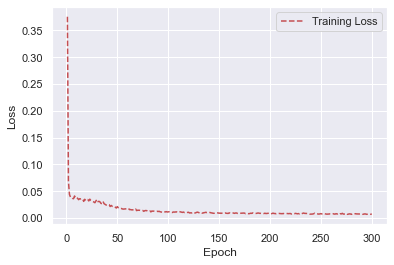

In [21]:
loss = history.history['loss']
epoch_count = range(1, len(loss) + 1)
plt.plot(epoch_count, loss, 'r--')
plt.legend(['Training Loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

앞으로 100일 동안의 주가 추이를 예측해 보도록 하겠습니다. 우리의 목표는 실제 가격이 아니라 추세를 예측하는 것임을 기억하십시오.

In [23]:
pred = model.predict(X_test_scaled)

In [24]:
y_true = y_test_scaled * sc2.scale_[0] + sc2.mean_[0]
y_pred = pred * sc2.scale_[0] + sc2.mean_[0]

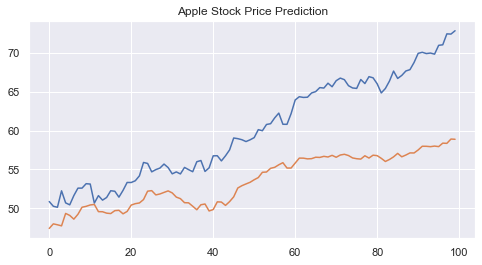

In [28]:
plt.figure(figsize=(8,4))
plt.plot(np.array(time_test), y_true)
plt.plot(np.array(time_test)[-len(pred):], y_pred)
plt.title('Apple Stock Price Prediction')
plt.show()

## 다양한 window_size tuning 을 하여 보다 정확한 예측을 시도